<a href="https://colab.research.google.com/github/yujuko/Photo-Paint/blob/master/photo_paint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
!pip install tensorflow==1.12.0
import tensorflow as tf
import numpy as np 
import scipy.io  
import argparse 
import struct
import errno                      
import cv2
import matplotlib.pyplot as plt
import copy

In [0]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
# unzip dataset
!unzip '/content/drive/My Drive/Colab Notebooks/artworks.zip'

Mounted at /content/drive/
Archive:  /content/drive/My Drive/Colab Notebooks/artworks.zip
replace artworks/resized/resized/Gustav_Klimt_113.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
%tensorflow_version 1.x

def build_model(input_img):
  
  net = {}
  _, h, w, d     = input_img.shape
 
  vgg_rawnet     = scipy.io.loadmat(args.model_weights)
  vgg_layers     = vgg_rawnet['layers'][0]
  
  net['input']   = tf.Variable(np.zeros((1, h, w, d), dtype=np.float32))

 
  net['conv1_1'] = conv_layer('conv1_1', net['input'], W=get_weights(vgg_layers, 0))
  net['relu1_1'] = relu_layer('relu1_1', net['conv1_1'], b=get_bias(vgg_layers, 0))

  net['conv1_2'] = conv_layer('conv1_2', net['relu1_1'], W=get_weights(vgg_layers, 2))
  net['relu1_2'] = relu_layer('relu1_2', net['conv1_2'], b=get_bias(vgg_layers, 2))
  
  net['pool1']   = pool_layer('pool1', net['relu1_2'])

  
  net['conv2_1'] = conv_layer('conv2_1', net['pool1'], W=get_weights(vgg_layers, 5))
  net['relu2_1'] = relu_layer('relu2_1', net['conv2_1'], b=get_bias(vgg_layers, 5))
  
  net['conv2_2'] = conv_layer('conv2_2', net['relu2_1'], W=get_weights(vgg_layers, 7))
  net['relu2_2'] = relu_layer('relu2_2', net['conv2_2'], b=get_bias(vgg_layers, 7))
  
  net['pool2']   = pool_layer('pool2', net['relu2_2'])
  
 
  net['conv3_1'] = conv_layer('conv3_1', net['pool2'], W=get_weights(vgg_layers, 10))
  net['relu3_1'] = relu_layer('relu3_1', net['conv3_1'], b=get_bias(vgg_layers, 10))

  net['conv3_2'] = conv_layer('conv3_2', net['relu3_1'], W=get_weights(vgg_layers, 12))
  net['relu3_2'] = relu_layer('relu3_2', net['conv3_2'], b=get_bias(vgg_layers, 12))

  net['conv3_3'] = conv_layer('conv3_3', net['relu3_2'], W=get_weights(vgg_layers, 14))
  net['relu3_3'] = relu_layer('relu3_3', net['conv3_3'], b=get_bias(vgg_layers, 14))

  net['conv3_4'] = conv_layer('conv3_4', net['relu3_3'], W=get_weights(vgg_layers, 16))
  net['relu3_4'] = relu_layer('relu3_4', net['conv3_4'], b=get_bias(vgg_layers, 16))

  net['pool3']   = pool_layer('pool3', net['relu3_4'])

  
  net['conv4_1'] = conv_layer('conv4_1', net['pool3'], W=get_weights(vgg_layers, 19))
  net['relu4_1'] = relu_layer('relu4_1', net['conv4_1'], b=get_bias(vgg_layers, 19))

  net['conv4_2'] = conv_layer('conv4_2', net['relu4_1'], W=get_weights(vgg_layers, 21))
  net['relu4_2'] = relu_layer('relu4_2', net['conv4_2'], b=get_bias(vgg_layers, 21))

  net['conv4_3'] = conv_layer('conv4_3', net['relu4_2'], W=get_weights(vgg_layers, 23))
  net['relu4_3'] = relu_layer('relu4_3', net['conv4_3'], b=get_bias(vgg_layers, 23))

  net['conv4_4'] = conv_layer('conv4_4', net['relu4_3'], W=get_weights(vgg_layers, 25))
  net['relu4_4'] = relu_layer('relu4_4', net['conv4_4'], b=get_bias(vgg_layers, 25))

  net['pool4']   = pool_layer('pool4', net['relu4_4'])

 
  net['conv5_1'] = conv_layer('conv5_1', net['pool4'], W=get_weights(vgg_layers, 28))
  net['relu5_1'] = relu_layer('relu5_1', net['conv5_1'], b=get_bias(vgg_layers, 28))

  net['conv5_2'] = conv_layer('conv5_2', net['relu5_1'], W=get_weights(vgg_layers, 30))
  net['relu5_2'] = relu_layer('relu5_2', net['conv5_2'], b=get_bias(vgg_layers, 30))

  net['conv5_3'] = conv_layer('conv5_3', net['relu5_2'], W=get_weights(vgg_layers, 32))
  net['relu5_3'] = relu_layer('relu5_3', net['conv5_3'], b=get_bias(vgg_layers, 32))

  net['conv5_4'] = conv_layer('conv5_4', net['relu5_3'], W=get_weights(vgg_layers, 34))
  net['relu5_4'] = relu_layer('relu5_4', net['conv5_4'], b=get_bias(vgg_layers, 34))

  net['pool5']   = pool_layer('pool5', net['relu5_4'])

  return net

def conv_layer(layer_name, layer_input, W):
  conv = tf.nn.conv2d(layer_input, W, strides=[1, 1, 1, 1], padding='SAME')
  return conv

def relu_layer(layer_name, layer_input, b):
  relu = tf.nn.relu(layer_input + b)
  return relu

def pool_layer(layer_name, layer_input): 
  pool = tf.nn.avg_pool(layer_input, ksize=[1, 2, 2, 1], 
    strides=[1, 2, 2, 1], padding='SAME')
  return pool

def get_weights(vgg_layers, i):
  weights = vgg_layers[i][0][0][2][0][0]
  W = tf.constant(weights)
  return W

def get_bias(vgg_layers, i):
  bias = vgg_layers[i][0][0][2][0][1]
  b = tf.constant(np.reshape(bias, (bias.size)))
  return b

def content_layer_loss(p, x):
  _, h, w, d = p.get_shape()
  M = h.value * w.value
  N = d.value
  if args.content_loss_function   == 1:
    K = 1. / (2. * N**0.5 * M**0.5)
  elif args.content_loss_function == 2:
    K = 1. / (N * M)
  elif args.content_loss_function == 3:  
    K = 1. / 2.
  loss = K * tf.reduce_sum(tf.pow((x - p), 2))
  return loss

def style_layer_loss(a, x):
  _, h, w, d = a.get_shape()
  M = h.value * w.value
  N = d.value
  A = gram_matrix(a, M, N)
  G = gram_matrix(x, M, N)
  loss = (1./(4 * N**2 * M**2)) * tf.reduce_sum(tf.pow((G - A), 2))
  return loss

def gram_matrix(x, area, depth):
  F = tf.reshape(x, (area, depth))
  G = tf.matmul(tf.transpose(F), F)
  return G

def sum_style_losses(sess, net, style_imgs):
  total_style_loss = 0.
  weights = args.style_imgs_weights
  for img, img_weight in zip(style_imgs, weights):
    sess.run(net['input'].assign(img))
    style_loss = 0.
    for layer, weight in zip(args.style_layers, args.style_layer_weights):
      a = sess.run(net[layer])
      x = net[layer]
      a = tf.convert_to_tensor(a)
      style_loss += style_layer_loss(a, x) * weight
    style_loss /= float(len(args.style_layers))
    total_style_loss += (style_loss * img_weight)
  total_style_loss /= float(len(style_imgs))
  return total_style_loss

def sum_content_losses(sess, net, content_img):
  sess.run(net['input'].assign(content_img))
  content_loss = 0.
  for layer, weight in zip(args.content_layers, args.content_layer_weights):
    p = sess.run(net[layer])
    x = net[layer]
    p = tf.convert_to_tensor(p)
    content_loss += content_layer_loss(p, x) * weight
  content_loss /= float(len(args.content_layers))
  return content_loss

def read_image(path):
  # bgr image
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  img = img.astype(np.float32)
  img = preprocess(img)
  return img

def preprocess(img):
  imgpre = np.copy(img)
  # bgr to rgb
  imgpre = imgpre[...,::-1]
  # shape (h, w, d) to (1, h, w, d)
  imgpre = imgpre[np.newaxis,:,:,:]
  imgpre -= np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
  return imgpre

def postprocess(img):
  imgpost = np.copy(img)
  imgpost += np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
  # shape (1, h, w, d) to (h, w, d)
  imgpost = imgpost[0]
  imgpost = np.clip(imgpost, 0, 255).astype('uint8')
  # rgb to bgr
  imgpost = imgpost[...,::-1]
  return imgpost

def normalize(weights):
  denom = sum(weights)
  if denom > 0.:
    return [float(i) / denom for i in weights]
  else: return [0.] * len(weights)

def get_content_image(content_img):
   # bgr image
  img = cv2.imread(content_img, cv2.IMREAD_COLOR)
  img = img.astype(np.float32)
  h, w, d = img.shape
  mx = args.max_size
  # resize if > max size
  if h > w and h > mx:
    w = (float(mx) / float(h)) * w
    img = cv2.resize(img, dsize=(int(w), mx), interpolation=cv2.INTER_AREA)
  if w > mx:
    h = (float(mx) / float(w)) * h
    img = cv2.resize(img, dsize=(mx, int(h)), interpolation=cv2.INTER_AREA)
  img = preprocess(img)
  return img

def get_style_images(content_img, style_img_path):
  _, ch, cw, cd = content_img.shape
  style_imgs = []
  for path in style_img_path:
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img.astype(np.float32)
    img = cv2.resize(img, dsize=(cw, ch), interpolation=cv2.INTER_AREA)
    img = preprocess(img)
    style_imgs.append(img)
  return style_imgs



def stylize(content_img, style_imgs, init_img):
  with tf.device(args.device), tf.Session() as sess:
    # setup network
    net = build_model(content_img)  
    # style loss
    L_style = sum_style_losses(sess, net, style_imgs) 
    # content loss
    L_content = sum_content_losses(sess, net, content_img)  
    # denoising loss
    L_tv = tf.image.total_variation(net['input'])
    
    # loss weights
    alpha = args.content_weight
    beta  = args.style_weight
    theta = args.tv_weight
    
    # total loss
    L_total  = alpha * L_content
    L_total += beta  * L_style
    L_total += theta * L_tv
    
    # optimization algorithm
    optimizer = get_optimizer(L_total)

    if args.optimizer == 'adam':
      minimize_with_adam(sess, net, optimizer, init_img, L_total)
    elif args.optimizer == 'lbfgs':
      minimize_with_lbfgs(sess, net, optimizer, init_img, L_total)
    
    output_img = sess.run(net['input'])
    
    # color preserving 
    output_img = convert_to_original_colors(np.copy(content_img), output_img)
    
    imgpost = np.copy(output_img)
    imgpost += np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
    imgpost = imgpost[0]
    imgpost = np.clip(imgpost, 0, 255).astype('uint8')
    # imgpost = imgpost[...,::-1]
    plt.imshow(imgpost)
    return imgpost

def print_loss(loss_evaled):
  print(loss_evaled)


def minimize_with_lbfgs(sess, net, optimizer, init_img, loss):
  init_op = tf.global_variables_initializer()
  sess.run(init_op)
  sess.run(net['input'].assign(init_img))
  optimizer.minimize(sess, loss_callback=print_loss, fetches=[loss])

def minimize_with_adam(sess, net, optimizer, init_img, loss):
  train_op = optimizer.minimize(loss)
  init_op = tf.global_variables_initializer()
  sess.run(init_op)
  sess.run(net['input'].assign(init_img))
  iterations = 0
  while (iterations < args.max_iterations):
    sess.run(train_op)
    iterations += 1

def get_optimizer(loss):
  if args.optimizer == 'lbfgs':
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(
      loss, method='L-BFGS-B',
      options={'maxiter': args.max_iterations})
  elif args.optimizer == 'adam':
    optimizer = tf.train.AdamOptimizer(args.learning_rate)
  return optimizer

def convert_to_original_colors(content_img, stylized_img):
  content_img  = postprocess(content_img)
  stylized_img = postprocess(stylized_img)
  cvt_type = cv2.COLOR_BGR2YUV
  inv_cvt_type = cv2.COLOR_YUV2BGR
  content_cvt = cv2.cvtColor(content_img, cvt_type)
  stylized_cvt = cv2.cvtColor(stylized_img, cvt_type)
  c1, _, _ = cv2.split(stylized_cvt)
  _, c2, c3 = cv2.split(content_cvt)
  merged = cv2.merge((c1, c2, c3))
  dst = cv2.cvtColor(merged, inv_cvt_type).astype(np.float32)
  dst = preprocess(dst)
  return dst

def render_result():
  content_img = get_content_image("/content/drive/My Drive/Colab Notebooks/green.jpg")
  style_img_path = args.style_img_path
  style_imgs = get_style_images(content_img, style_img_path)
  with tf.Graph().as_default():
    result_img = stylize(content_img, style_imgs, content_img)
  return result_img

In [0]:
class Args(object):
  pass

args = Args();
args.max_size = 512
args.content_weight = 5e4
args.style_weight = 1e7
args.tv_weight = 10
args.content_loss_function = 1
args.content_layers =  ['relu4_2']
args.style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
args.content_layer_weights = [1.0]
args.style_layer_weights = [0.2, 0.2, 0.2, 0.2, 0.2]
args.noise_ratio = 1.0
args.seed = 0
args.model_weights = '/content/drive/My Drive/Colab Notebooks/imagenet-vgg-verydeep-19.mat' # https://www.vlfeat.org/matconvnet/pretrained/ 
args.device = '/cpu:0'
args.optimizer = 'lbfgs'
args.learning_rate = 0.1
args.max_iterations = 1000
args.content_name = 'green.jpg'



In [0]:
import numpy as np

base_path = 'artworks/resized/resized/'
artist_name = 'Pablo_Picasso_'
# Piet_Mondrian
# Pablo_Picasso
# Vincent_van_Gogh

style_img_path = []
# 50 images 
for count in range(1, 5):
  path = base_path + artist_name + str(count) + '.jpg'
  style_img_path.append(path)
# weight for each one
style_imgs_weights =  0.2 * np.ones(count)

In [0]:
args.style_imgs_weights = style_imgs_weights
args.style_img_path = style_img_path
args.style_layer_weights   = normalize(args.style_layer_weights)
args.content_layer_weights = normalize(args.content_layer_weights)
args.style_imgs_weights    = normalize(args.style_imgs_weights)

[6.2550494e+13]
[6.254455e+13]
[6.2520836e+13]
[6.242634e+13]
[6.2055256e+13]
[6.0718074e+13]
[5.326371e+13]
[5.0038424e+13]
[4.7614293e+13]
[4.576462e+13]
[4.3891714e+13]
[4.2711848e+13]
[4.213841e+13]
[4.147931e+13]
[4.094715e+13]
[4.0245496e+13]
[4.0419388e+13]
[3.986498e+13]
[3.9293343e+13]
[3.876482e+13]
[3.8310278e+13]
[3.782563e+13]
[3.7418586e+13]
[3.694065e+13]
[3.6678945e+13]
[3.641717e+13]
[3.6288137e+13]
[3.60965e+13]
[3.593606e+13]
[3.5942564e+13]
[3.5861098e+13]
[3.579694e+13]
[3.5703598e+13]
[3.5595133e+13]
[3.5509326e+13]
[3.5448592e+13]
[3.5395232e+13]
[3.535156e+13]
[3.530313e+13]
[3.5276215e+13]
[3.5236885e+13]
[3.519062e+13]
[3.517606e+13]
[3.5147932e+13]
[3.511165e+13]
[3.5077386e+13]
[3.5042353e+13]
[3.5020763e+13]
[3.4995092e+13]
[3.4973552e+13]
[3.4958087e+13]
[3.4939863e+13]
[3.4908106e+13]
[3.4882093e+13]
[3.4866417e+13]
[3.4850136e+13]
[3.4835205e+13]
[3.482336e+13]
[3.4811538e+13]
[3.4799578e+13]
[3.4784636e+13]
[3.4770522e+13]
[3.4758902e+13]
[3.4743997e+13

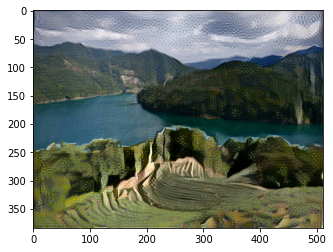

In [0]:
result_img = render_result()

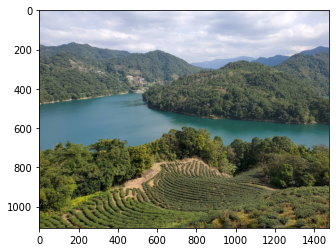

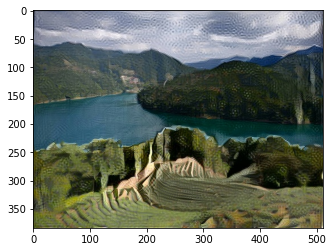

In [0]:
content_path = "/content/drive/My Drive/Colab Notebooks/" + args.content_name
img=cv2.imread(content_path)
img = img[...,::-1]
img = plt.imshow(img)
plt.show()
result_path = "/content/drive/My Drive/Colab Notebooks/green_Pablo_Picasso_2.jpg"
cv2.imwrite(result_path, cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR))
imgr=cv2.imread(result_path)
imgr = imgr[...,::-1]
imgr = plt.imshow(imgr)
plt.show()



In [0]:
import numpy as np

arr_iter = [838, 798, 704, 719, 746, 865, 838, 758, 805, 809]
mean_iter = np.mean(arr_iter)
std_iter = np.std(arr_iter)
print("mean:", mean_iter, "std:", std_iter )

In [0]:
import math
arr_loss = [3.4961348, 3.496186, 3.4962722, 3.4962447, 3.4962276, 3.496115, 3.496158, 3.4962192, 3.4961697, 3.496157]
# e12
mean_loss = np.mean(arr_loss)
std_loss = np.std(arr_loss)
t = 2.262
ci_loss = t * std_loss / math.sqrt(10)
ci_iter = t * std_iter / math.sqrt(10)
print("mean:", mean_loss, "std:", std_loss)
print(ci_iter, ci_loss)

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/no_color_pers.jpg'
cv2.imwrite(path, impost)
# args.content_layers =  ['conv4_2']
# args.style_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
